## What is the most optimal skill to learn for Data Analysts?

### Methodology

1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevelant

In [1]:
# import libraries

import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# loading data

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# data cleanup

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# use apply() to clean 'job_skills' >> makes the column a list datatype instead of string

df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else(x))

In [2]:
# filter for job titles and country

df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [5]:
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [11]:
# grouping dataframe

df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

#rename columns
df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)

#create new column for skill percent
df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

skill_percent = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


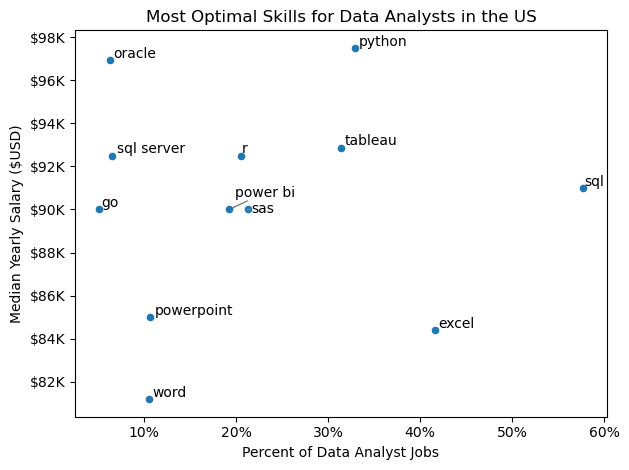

In [18]:
# adjusting text on plot

from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color ='gray', lw=1))

# adjusting axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

plt.tight_layout()
plt.show()



In [20]:
# creating dictionary to group technologies

df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

# remove duplicates by converitng values to set them back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['spss',
  'microstrategy',
  'splunk',
  'ssis',
  'sharepoint',
  'qlik',
  'dax',
  'power bi',
  'sas',
  'powerpoint',
  'nuix',
  'outlook',
  'datarobot',
  'cognos',
  'sap',
  'sheets',
  'ms access',
  'tableau',
  'esquisse',
  'excel',
  'alteryx',
  'spreadsheet',
  'msaccess',
  'looker',
  'powerbi',
  'ssrs',
  'word',
  'visio'],
 'programming': ['perl',
  'vba',
  'clojure',
  'c',
  'c++',
  'matlab',
  'swift',
  'groovy',
  'crystal',
  'lua',
  'c#',
  'ruby',
  'fortran',
  't-sql',
  'sass',
  'go',
  'scala',
  'typescript',
  'visual basic',
  'bash',
  'delphi',
  'python',
  'mongodb',
  'sas',
  'ocaml',
  'visualbasic',
  'lisp',
  'cobol',
  'powershell',
  'julia',
  'css',
  'golang',
  'kotlin',
  'sql',
  'nosql',
  'erlang',
  'html',
  'f#',
  'r',
  'pascal',
  'apl',
  'elixir',
  'rust',
  'dart',
  'objective-c',
  'solidity',
  'javascript',
  'shell',
  'java',
  'haskell',
  'mongo',
  'assembly',
  'vb.net',
  'php',
  'no-

In [23]:
# creating dataframe from dictionary

df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

# break out skills column
df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,spss
0,analyst_tools,microstrategy
0,analyst_tools,splunk
0,analyst_tools,ssis
0,analyst_tools,sharepoint
...,...,...
9,sync,webex
9,sync,ringcentral
9,sync,unify
9,sync,google chat


In [25]:
# merging back to original dataframe

df_plot = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')

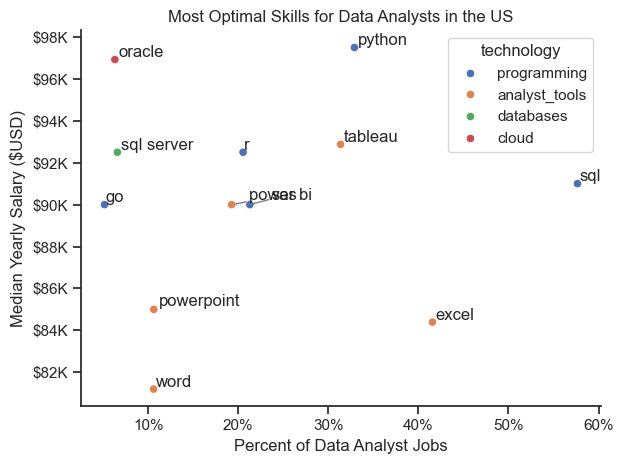

In [30]:
# recreating plot

from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

# df_plot.plot(kind='scatter', x='skill_percent', y='median_salary')

sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color ='gray', lw=1))

# adjusting axis
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

plt.tight_layout()
plt.show()